# The link of the data set:
https://www.kaggle.com/crowww/a-large-scale-fish-dataset

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import random
from pathlib import Path
import os

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [2]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 15 , 'CPU': 58} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

## Show a example of the data

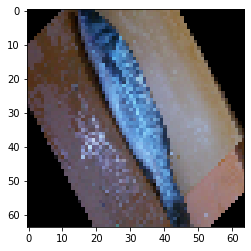

In [3]:
img = cv.imread("../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00001.png")
img = cv.resize(img, (64,64))
plt.imshow(img)

## Make a Data Frame with the image path and it's label 

In [4]:
file = Path("../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")
File_Path = list(file.glob(r"**/*.png"))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],File_Path))

# Convert to series then contact them as a data frame, rename the columns
File_Path = pd.Series(File_Path).astype(str)
Labels = pd.Series(Labels)
df = Main_Data = pd.concat([File_Path,Labels],axis=1)
df.columns = ['image', 'label']
# Drop all the images that ends with (GT)
df = df[df["image"].apply(lambda x: x[-2:] != "GT")]
df = df.reset_index(drop=True)
# Show the last 5 rows
df.tail()

,image,label
17995,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17996,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17997,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17998,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT
17999,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream GT


## Explore the classes

In [5]:
classes = df['label'].unique()
print(f'\nThe Classes:\n {classes} ')


The Classes:
 ['Hourse Mackerel' 'Hourse Mackerel GT' 'Black Sea Sprat GT'
 'Black Sea Sprat' 'Sea Bass' 'Sea Bass GT' 'Red Mullet' 'Red Mullet GT'
 'Trout' 'Trout GT' 'Striped Red Mullet GT' 'Striped Red Mullet'
 'Shrimp GT' 'Shrimp' 'Gilt-Head Bream GT' 'Gilt-Head Bream'
 'Red Sea Bream' 'Red Sea Bream GT'] 


## Read the images, Split the data: Train/Validation/Test

In [6]:
# Make a list that contains all the file paths for images and it's label
file = Path("../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")
File_Path = list(file.glob(r"**/*.png"))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],File_Path))

# Convert to series then contact them as a data frame, rename the columns
File_Path = pd.Series(File_Path).astype(str)
Labels = pd.Series(Labels)
df = Main_Data = pd.concat([File_Path,Labels],axis=1)
df.columns = ['image', 'label']
# Drop all the images that ends with (GT)
df = df[df["label"].apply(lambda x: x[-2:] != "GT")]
df = df.reset_index(drop=True)
# Get a 500 random values/rows
rand = random.sample(range(len(df)), 500)
# Make the random 500 as a validation data
validation_set = pd.DataFrame(df.iloc[rand, :].values, columns=['image', 'label'])
# Drop the 500 from the orignal data set
df.drop(rand, inplace=True)
# Get a 5 random rows/values from the validation set
rand = random.sample(range(len(validation_set)), 5)
# from the 5 random Create the test set 
test_set = pd.DataFrame(validation_set.iloc[rand, :].values, columns=['image', 'label'])
# Drop the 5 from the validation set
validation_set.drop(rand, inplace=True)
# The number of unique values in the label column
print('The number of unique values in the label column: ',len(df['label'].unique()))
# Show the Test set as a example of the data
test_set

The number of unique values in the label column:  9


,image,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet


## Create the Generators

In [7]:
DATADIR = ''
train_data_generator = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2)
data_generator = ImageDataGenerator(rescale=1/255)
training_data_frame = train_data_generator.flow_from_dataframe(dataframe=df, directory=DATADIR, x_col='image', y_col='label', 
                                                               target_size=(64, 64), class_mode='categorical')
validation_data_frame = data_generator.flow_from_dataframe(dataframe=validation_set, directory=DATADIR, x_col='image', y_col='label', 
                                                           target_size=(64, 64), class_mode='categorical')
test_data_frame = data_generator.flow_from_dataframe(dataframe=test_set, directory=DATADIR, x_col='image', y_col='label', 
                                                     target_size=(64, 64), class_mode='categorical', shuffle=False)

Found 8500 validated image filenames belonging to 9 classes.
Found 495 validated image filenames belonging to 9 classes.
Found 5 validated image filenames belonging to 5 classes.


In [10]:
# Define the model
model = Sequential()

# Add first Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(64,64,3)))
# Add a relu Activation 
model.add(Activation('relu'))
# Add a second Convolutional Layer
model.add(Conv2D(64, (3, 3)))
# Add a relu Activation 
model.add(Activation('relu'))
# Add a Max pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Add a Dropout layer
model.add(Dropout(0.25))

# Add third Convolutional Layer
model.add(Conv2D(128, (3, 3), padding='same'))
# Add a relu Activation 
model.add(Activation('relu'))
# Add Fourth Convolutional Layer
model.add(Conv2D(128, (3, 3)))
# Add a relu Activation 
model.add(Activation('relu'))
# Add a Max pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Add a Dropout Layer
model.add(Dropout(0.25))

# Add Fifth Convolutional Layer
model.add(Conv2D(256, (3, 3), padding='same'))
# Add a Activation Layer
model.add(Activation('relu'))
# Add a sixth Convolutional Layer
model.add(Conv2D(256, (3, 3)))
# Add a Activation Layer
model.add(Activation('relu'))
# Add a Max Pooling Layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Add a Dropout Layer
model.add(Dropout(0.25))

# Add a Flatten Layer
model.add(Flatten())
# Add a Dense layer Layer
model.add(Dense(512))
# Add a Activation Layer
model.add(Activation('relu'))
# Add a Dropout Layer
model.add(Dropout(0.5))
# Add the Output Dense Layer
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Train the model for 50 epochs
history = model.fit(training_data_frame, validation_data=validation_data_frame, epochs=20)

Epoch 1/20
266/266 [==============================] - 200s 747ms/step - loss: 2.0451 - accuracy: 0.2140 - val_loss: 1.3538 - val_accuracy: 0.5131
Epoch 2/20
266/266 [==============================] - 105s 394ms/step - loss: 1.3438 - accuracy: 0.5063 - val_loss: 1.1570 - val_accuracy: 0.5798
Epoch 3/20
266/266 [==============================] - 103s 388ms/step - loss: 1.0706 - accuracy: 0.6079 - val_loss: 0.7320 - val_accuracy: 0.7212
Epoch 4/20
266/266 [==============================] - 105s 394ms/step - loss: 0.8480 - accuracy: 0.6957 - val_loss: 0.4628 - val_accuracy: 0.8384
Epoch 5/20
266/266 [==============================] - 104s 392ms/step - loss: 0.6633 - accuracy: 0.7656 - val_loss: 0.5250 - val_accuracy: 0.8081
Epoch 6/20
266/266 [==============================] - 105s 394ms/step - loss: 0.5138 - accuracy: 0.8150 - val_loss: 0.9881 - val_accuracy: 0.7071
Epoch 7/20
266/266 [==============================] - 104s 392ms/step - loss: 0.4580 - accuracy: 0.8319 - val_loss: 0.3532 -

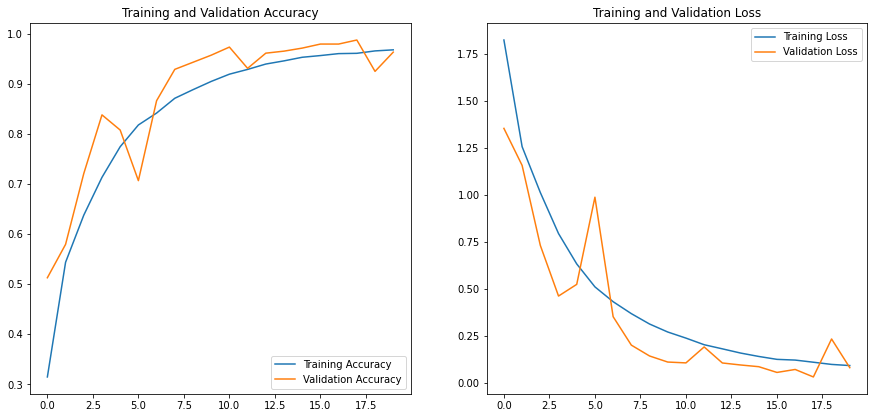

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

In [13]:
# Save the model as model.h5
model.save('model.h5')
# Load the model
model = load_model('model.h5')

Prediction Dict:  {'Black Sea Sprat': 0, 'Gilt-Head Bream': 1, 'Hourse Mackerel': 2, 'Red Mullet': 3, 'Red Sea Bream': 4, 'Sea Bass': 5, 'Shrimp': 6, 'Striped Red Mullet': 7, 'Trout': 8}
Max index:  [4, 8, 1, 6, 7]
Predicted:  Red Sea Bream /Real:  Red Sea Bream


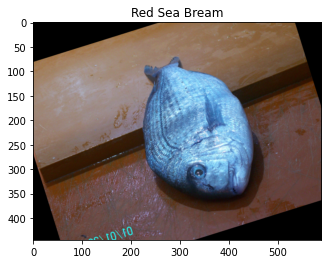

Predicted:  Trout /Real:  Trout


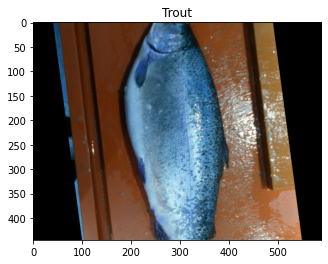

Predicted:  Gilt-Head Bream /Real:  Gilt-Head Bream


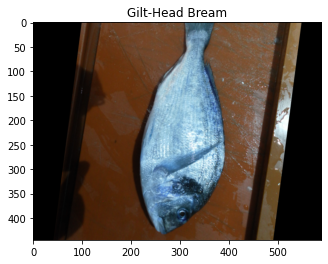

Predicted:  Shrimp /Real:  Shrimp


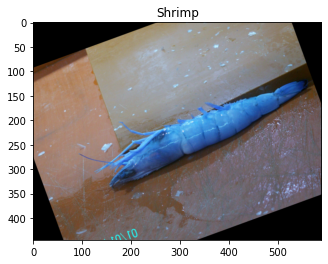

Predicted:  Striped Red Mullet /Real:  Striped Red Mullet


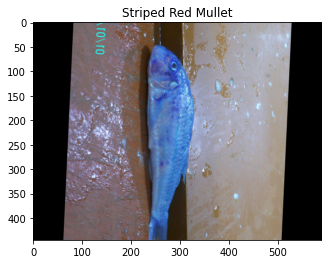

In [24]:
# Print the class indices 
print("Prediction Dict: ", training_data_frame.class_indices)
# Predict on the test data 
pred = model.predict(test_data_frame)
# Create a class/labels dictionary
classDict = { 
                 0:'Black Sea Sprat',
                 1:'Gilt-Head Bream',
                 2:'Hourse Mackerel',
                 3:'Red Mullet',
                 4:'Red Sea Bream',
                 5:'Sea Bass',
                 6:'Shrimp',
                 7:'Striped Red Mullet',
                 8:'Trout'}

# Make a data frame that contains the probability for each class
outputDf = pd.DataFrame(pred)
# Get the index of the max probability from the output Data frame
maxIndex = list(outputDf.idxmax(axis=1))
# Print the max index
print("Max index: ", maxIndex)
# Make a loop in range the length of the test data (5)
for i in range(len(test_set)):
    # Read the image 
    image = cv.imread(test_set['image'][i])
    # The title of the plot which is the predicted label
    print('Predicted: ',classDict.get(maxIndex[i], "error"),'/Real: ',test_set['label'][i])
    plt.title(classDict.get(maxIndex[i], "error"))
    # Show the actual image
    plt.imshow(image)
    plt.show()
    